In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections
import pandas as pd
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

# Get Data

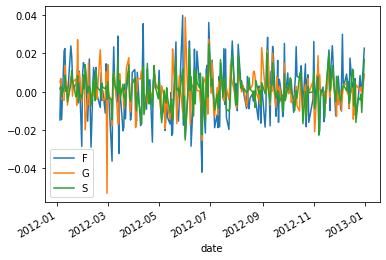

In [2]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()

# Combine Seperate DFs into one
ret_df = pd.DataFrame()
for k , v in data.items():
    # Create Returns and Directional Movement
    v.sort_index(ascending = True, inplace = True)
    v["ret"] = v["close"].pct_change()
    v.dropna(axis = 0 , inplace = True)
    v["dir"] = v["ret"].apply(lambda x: 1 if x >= 0  else 0)
    v["prod"] = k
    ret_df = pd.concat([ret_df , v[["ret"]]] , axis = 1)
    
ret_df.columns = data.keys()
ret_df.plot()

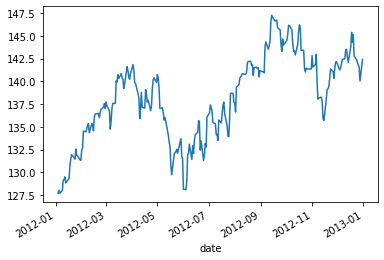

In [46]:
data["S"]["close"].plot()

# 1. Model with just local linear trend

## 1.1 Build Model

In [23]:
def build_model(observed_time_series_, other_effects_):

    # Other effects
    linear_reg = sts.LinearRegression(design_matrix = other_effects_, name='other_effects')
    
    # Autoregressive effect
    autoregressive = sts.Autoregressive(order=1,observed_time_series=observed_time_series_, name='ar')
    
    # Final Model
    model = sts.Sum([linear_reg,autoregressive], observed_time_series=observed_time_series_)
    return model

In [31]:
# Tidy Data
other_effects = tf.reshape(ret_df[["F","G"]] - np.mean(ret_df[["F","G"]], axis = 0), (-1, 1))
observed_time_series = ret_df["S"].values
model_ar = build_model(observed_time_series, other_effects)

## 1.2 Fit Model

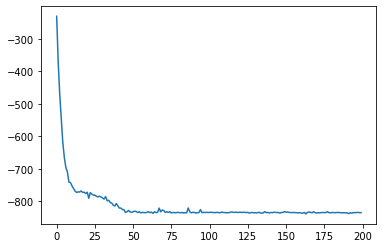

In [32]:
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model_ar)

num_variational_steps = 200 
num_variational_steps = int(num_variational_steps)


optimizer = tf.optimizers.Adam(learning_rate=.1)

@tf.function(experimental_compile=True)
def train(observed_time_series_):
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
                        target_log_prob_fn=model_ar.joint_log_prob(
                                                observed_time_series=observed_time_series_),
                                                surrogate_posterior=variational_posteriors,
                                                optimizer=optimizer,
                                                num_steps=num_variational_steps)
    return elbo_loss_curve

elbo_loss_curve = train(observed_time_series)
plt.plot(elbo_loss_curve)
plt.show()

# 1.3 Draw Samples and Forecast

In [33]:
# Draw samples from the variational posterior.
samples_ar = variational_posteriors.sample(50)
print("Inferred parameters:")
for param in model_ar.parameters:
    print("{}: {} +- {}".format(param.name,
                              np.mean(samples_ar[param.name], axis=0),
                              np.std(samples_ar[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 0.008003606005379346 +- 0.0004598192070558176
other_effects/_weights: [-0.02572484] +- [0.04239631]
ar/_coefficients: [0.13498904] +- [0.46982853]
ar/_level_scale: 0.0006029630627483738 +- 0.0005642652123756219


In [41]:
num_forecast_steps = 100
num_samples = 100
forecast_dist = tfp.sts.forecast(
    model=model_ar,
    observed_time_series=observed_time_series,
    parameter_samples=samples_ar,
    num_steps_forecast=num_forecast_steps)


In [42]:
(
    forecast_mean,
    forecast_scale,
    forecast_samples
) = (
    forecast_dist.mean().numpy()[..., 0],
    forecast_dist.stddev().numpy()[..., 0],
    forecast_dist.sample(num_samples).numpy()[..., 0]
    )

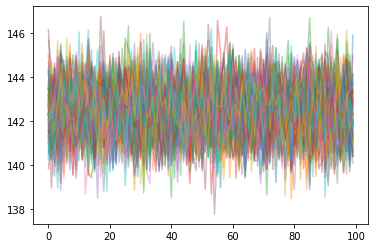

In [51]:
for i in range( forecast_samples.shape[0]):
    path = [data["S"]["close"].iloc[-1] * (1 + r) for r in forecast_samples[i,:]]
    plt.plot(path , alpha = 0.4 )
    